In [1]:
using BSON: @save, @load
using Statistics, DelimitedFiles, Printf
include("../MDToolbox.jl/src/MDToolbox.jl")
using .MDToolbox
using StatsBase 

In [2]:
qs = readdlm("data/quaternion/QUATERNION_LIST_576_Orient")
models = readpdb("data/t1r/cluster.pdb")
nmodel = size(models, 1)
nframe = 100
nq = size(qs, 1)
sigma_noise = 3.0
test_num = 1

1

In [3]:
function make_merged_T(ids, T)
    ret_T = zeros(nmodel, nmodel)
    nid = size(ids, 1)
    for i in 1:nid
        i_state = ids[i][1]
        for j in 1:nid
            j_state = ids[j][1]
            ret_T[i_state, j_state] += T[i, j]
        end
        
    end

    for i in 1:nmodel
        if sum(ret_T[i, :]) <= 1e-100
            continue 
        end
        ret_T[i, :] ./= sum(ret_T[i, :])
    end

    return ret_T
end

make_merged_T (generic function with 1 method)

In [4]:
init_Ts = []
learned_Ts = []
titles = []
test_radii = [20, 20, 25, 30, 30]
pred_radii = [25, 30, 25, 20, 25]
for i in 1:size(test_radii, 1)
    test_radius = test_radii[i]
    pred_radius = pred_radii[i]

    @load "data/01_result/test_radius_$(test_radius)_pred_radius_$(pred_radius)/statistics_$(test_num)_ids.bson" ids extracted_qs 
    @load "data/01_result/test_radius_$(test_radius)_pred_radius_$(pred_radius)/statistics_$(test_num)_params.bson" init_T1 init_T2 T1 T2 pi_i1 pi_i2
    push!(init_Ts, make_merged_T(ids, init_T2));
    push!(learned_Ts, make_merged_T(ids, T2));
    push!(titles, "test $(test_radius) pred $(pred_radius)")
end

In [5]:
@load "data/t1r/t1r.bson" T pi_i centroid

In [6]:
using PyPlot

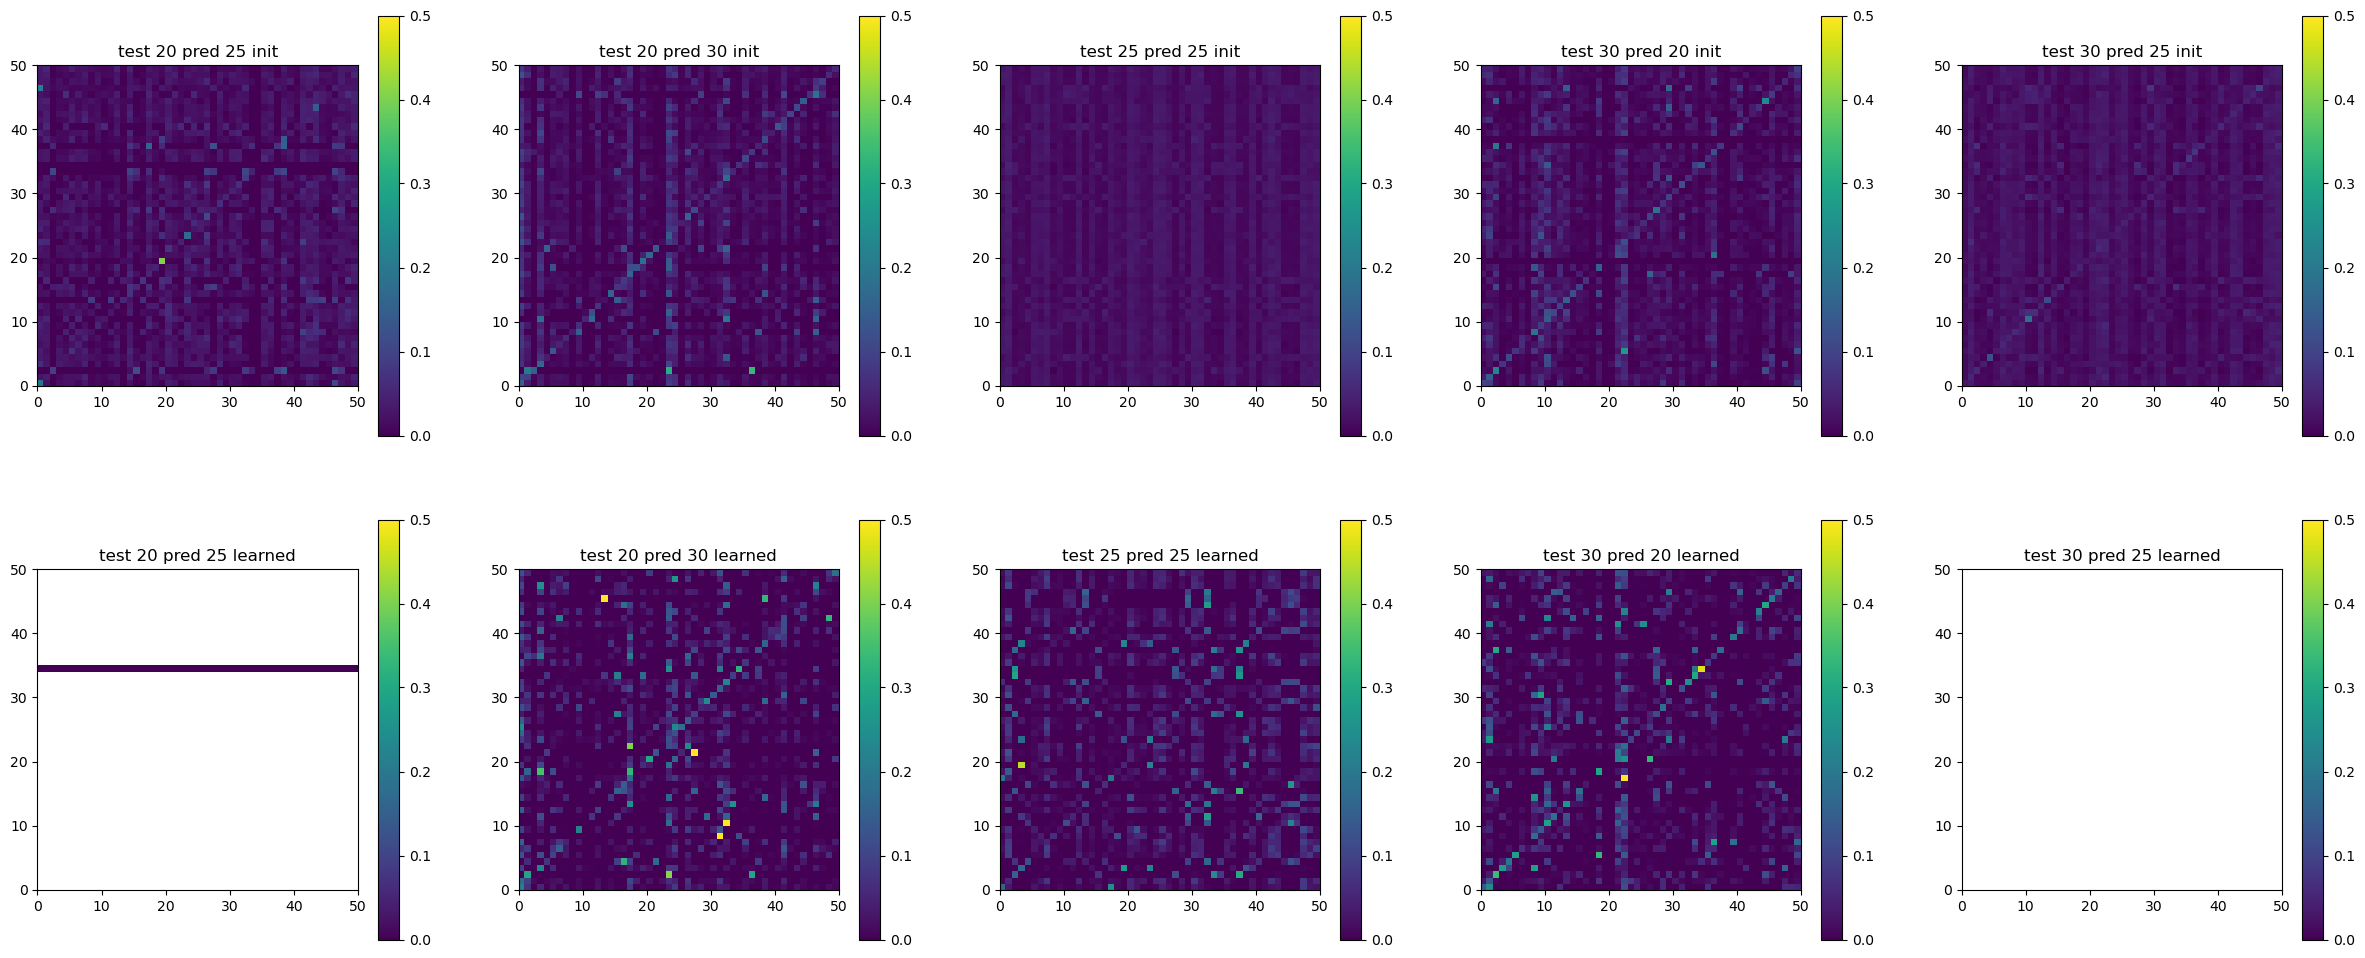

In [7]:
fig, axes = subplots(2,5, figsize=(30,12))
for i in 1:size(test_radii, 1)
    mp = axes[1, i].pcolor(init_Ts[i], vmin=0, vmax=0.5)
    colorbar(mp, ax=axes[1, i], orientation="vertical")
    axes[1, i].set_aspect(:equal)
    axes[1, i].set_title(titles[i] * " init")
    
    mp = axes[2, i].pcolor(learned_Ts[i], vmin=0, vmax=0.5)
    colorbar(mp, ax=axes[2, i], orientation="vertical")
    axes[2, i].set_aspect(:equal)
    axes[2, i].set_title(titles[i] * " learned")
end

savefig("01_learned_transition_probability.png", dpi=200)